In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy, sqlite3, h5py, sys, os

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler

import rampy as rp

import imelt

In [4]:
def pretreatment(dataset,split_valid,output_file, rand_state=81):

    print('Reading data...')
    # reading the Pandas dataframe
    dataset = imelt.chimie_control(dataset)

    #
    # For viscosity
    #
    
    # train-valid-test split
    print("Splitting datasets...\n")
    tv_sub, test_sub, idxtv_sub, idxtest_sub = rp.chemical_splitting(dataset,'Name',
                                                                     split_fraction=0.20, 
                                                                     rand_state=rand_state)
    train_sub, valid_sub, idxtrain_sub, idxvalid_sub = rp.chemical_splitting(tv_sub,'Name',
                                                                             split_fraction=split_valid, 
                                                                             rand_state=rand_state)
    
    X_columns = ["sio2","al2o3","na2o","k2o","T"] # for output
    X_train = train_sub.loc[:,X_columns].values
    X_valid = valid_sub.loc[:,X_columns].values
    X_test = test_sub.loc[:,X_columns].values
    
    y_train = train_sub["viscosity"].values.reshape(-1,1)
    y_valid = valid_sub["viscosity"].values.reshape(-1,1)
    y_test = test_sub["viscosity"].values.reshape(-1,1)
    
    #
    # For entropy
    #
    # we drop all rows without entropy values and get only one value per composition
    #
    dataset_entropy = dataset.dropna(subset=['Sc']).copy()
    dataset_entropy.drop_duplicates(subset ="Name",keep = "first", inplace = True)

    # 70-15-15 split
    train_entropy, tv_entropy = model_selection.train_test_split(dataset_entropy, test_size=0.30, random_state=rand_state)
    test_entropy, valid_entropy = model_selection.train_test_split(tv_entropy, test_size=0.5, random_state=rand_state)
    
    X_columns = ["sio2","al2o3","na2o","k2o"] # for output
    X_entropy_train = train_entropy.loc[:,X_columns].values
    X_entropy_valid = valid_entropy.loc[:,X_columns].values
    X_entropy_test = test_entropy.loc[:,X_columns].values
    
    y_entropy_train = train_entropy.loc[:,"Sc"].values
    y_entropy_valid = valid_entropy.loc[:,"Sc"].values
    y_entropy_test = test_entropy.loc[:,"Sc"].values
    
    #
    # for Tg
    # we grab the Tgs associated with the train-valid-test split of viscosity data
    # (as Tg is not used for training per se)
    #
     
    # we drop the values at 0 (Tg not determined)
    train_tg = train_sub[train_sub.tg != 0]
    valid_tg = valid_sub[valid_sub.tg != 0]
    test_tg = test_sub[test_sub.tg != 0]
    
    # for output
    X_tg_train = train_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    X_tg_valid = valid_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    X_tg_test = test_tg.loc[:,["sio2","al2o3","na2o","k2o"]].values
    
    y_tg_train = train_tg.loc[:,"tg"].values
    y_tg_valid = valid_tg.loc[:,"tg"].values
    y_tg_test = test_tg.loc[:,"tg"].values

    # Figure of the datasets
    plt.figure()
    plt.subplot(121)
    plt.plot(10000/X_train[:,4],y_train,"k.")

    plt.subplot(121)
    plt.plot(10000/X_valid[:,4],y_valid,"b.")

    plt.subplot(121)
    plt.plot(10000/X_test[:,4],y_test,"r.")
    plt.show()

    print("Size of viscous training subsets:\n")
    print(X_train.shape)
    
       
    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))

        f.create_dataset('X_entropy_train', data=X_entropy_train)
        f.create_dataset('y_entropy_train', data=y_entropy_train.reshape(len(y_entropy_train),1))
        
        f.create_dataset('X_entropy_valid', data=X_entropy_valid)
        f.create_dataset('y_entropy_valid', data=y_entropy_valid.reshape(len(y_entropy_valid),1))
        
        f.create_dataset('X_entropy_test', data=X_entropy_test)
        f.create_dataset('y_entropy_test', data=y_entropy_test.reshape(len(y_entropy_test),1))
        
        f.create_dataset('X_tg_train',data=X_tg_train)
        f.create_dataset('X_tg_valid',data=X_tg_valid)
        f.create_dataset('X_tg_test',data=X_tg_test)
        
        f.create_dataset('y_tg_train',data=y_tg_train.reshape(len(y_tg_train),1))
        f.create_dataset('y_tg_valid',data=y_tg_valid.reshape(len(y_tg_valid),1))
        f.create_dataset('y_tg_test',data=y_tg_test.reshape(len(y_tg_test),1))

        f.create_dataset('X_train', data=X_train)
        f.create_dataset('y_train', data=y_train)
        
        f.create_dataset('X_valid', data=X_valid)
        f.create_dataset('y_valid', data=y_valid)
        
        f.create_dataset('X_test', data=X_test)
        f.create_dataset('y_test', data=y_test)

Index(['Name', 'sio2', 'al2o3', 'na2o', 'k2o', 'tg', 'T', 'viscosity', 'ref',
       'Sc', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27'],
      dtype='object')
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


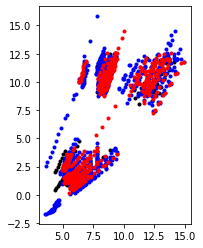

Size of viscous training subsets:

(256, 5)
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


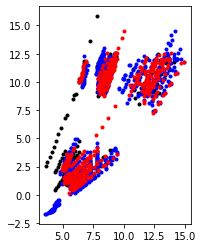

Size of viscous training subsets:

(423, 5)
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


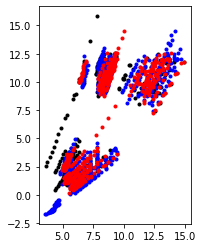

Size of viscous training subsets:

(569, 5)
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


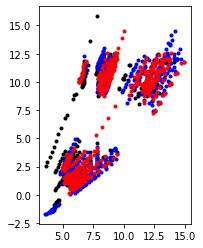

Size of viscous training subsets:

(700, 5)


<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


Reading data...
Splitting datasets...



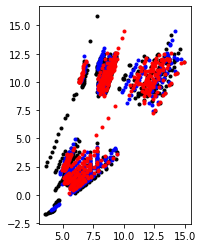

Size of viscous training subsets:

(878, 5)
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


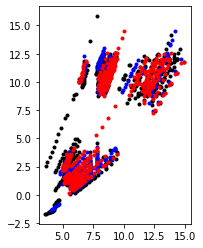

Size of viscous training subsets:

(1005, 5)
Reading data...
Splitting datasets...



<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


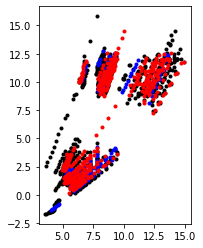

<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


Size of viscous training subsets:

(1153, 5)
Reading data...
Splitting datasets...



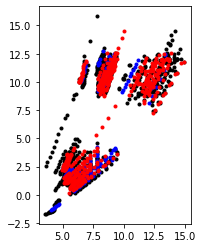

Size of viscous training subsets:

(1198, 5)


<ipython-input-4-6d943d83d909>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-4-6d943d83d909>:78: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


Reading data...
Splitting datasets...



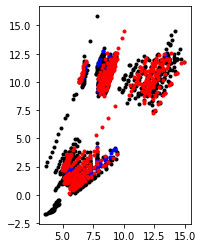

Size of viscous training subsets:

(1304, 5)


In [5]:
# KNAS, comment to deactivate
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
print(dataset.columns)

fractions_vt = [0.80,0.70,0.60,0.50,0.40,0.30,0.20,0.17,0.10]
prefix= ["_0p80val","_0p70val","_0p60val","_0p50val","_0p40val","_0p30val","_0p20val","_reference", "_0p10val"]

for indice,value in enumerate(fractions_vt):
    pretreatment(dataset,value,"./data/NKAS_viscosity"+prefix[indice]+".hdf5", rand_state=81)

# Density preparation

In [6]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="DENSITY")
dataset.head()

def prepare_density(dataset,output_file):
    
    # Import data
    dataset = imelt.chimie_control(dataset)
    X_d = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]
    y_d = dataset.loc[:, ["d"]]
    
    # train-test split
    # 70-15-15
    X_train, X_vt, y_train, y_vt = model_selection.train_test_split(X_d, y_d, test_size=0.30, random_state=42)
    X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)
    
    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_density_train', data=X_train)
        f.create_dataset('X_density_valid', data=X_valid)
        f.create_dataset('X_density_test',  data=X_test)

        f.create_dataset('y_density_train', data=y_train)
        f.create_dataset('y_density_valid', data=y_valid)
        f.create_dataset('y_density_test',  data=y_test)
        
    print("Done.")
        
prepare_density(dataset,"./data/NKAS_density.hdf5")

Done.


# Refractive Index preparation

In [7]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="OPTICAL")
dataset.head()

def prepare_ri(dataset,output_file):
    
    # Import data
    dataset = imelt.chimie_control(dataset)
    X_d = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]
    lbd_d = dataset.loc[:, ["lbd"]]*1e-3
    y_d = dataset.loc[:, ["ri"]]*1.0

    # train-test split
    # 70-15-15
    X_train, X_vt, lbd_train, lbd_vt, y_train, y_vt = model_selection.train_test_split(X_d, lbd_d, y_d, 
                                                                                      test_size=0.30, random_state=42)
    X_valid, X_test, lbd_valid, lbd_test, y_valid, y_test = model_selection.train_test_split(X_vt, lbd_vt, y_vt, test_size=0.5, random_state=42)
    
    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_ri_train', data=X_train)
        f.create_dataset('X_ri_valid', data=X_valid)
        f.create_dataset('X_ri_test',  data=X_test)

        f.create_dataset('lbd_ri_train', data=lbd_train)
        f.create_dataset('lbd_ri_valid', data=lbd_valid)
        f.create_dataset('lbd_ri_test',  data=lbd_test)

        f.create_dataset('y_ri_train', data=y_train)
        f.create_dataset('y_ri_valid', data=y_valid)
        f.create_dataset('y_ri_test',  data=y_test)

    print("Done.")
        
prepare_ri(dataset,"./data/NKAS_optical.hdf5")

Done.


# Raman spectra preparation

62
Spectra 0, checking array size: 2351
Spectra 1, checking array size: 2351
Spectra 2, checking array size: 2351
Spectra 3, checking array size: 2351
Spectra 4, checking array size: 2083
Spectra 5, checking array size: 2429
Spectra 6, checking array size: 2058
Spectra 7, checking array size: 2429


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 8, checking array size: 2434
Spectra 9, checking array size: 2436
Spectra 10, checking array size: 2434
Spectra 11, checking array size: 2436
Spectra 12, checking array size: 2442
Spectra 13, checking array size: 2429
Spectra 14, checking array size: 2442
Spectra 15, checking array size: 2436


<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:

Spectra 16, checking array size: 2434
Spectra 17, checking array size: 2266
Spectra 18, checking array size: 2434
Spectra 19, checking array size: 2429
Spectra 20, checking array size: 2014
Spectra 21, checking array size: 2014
Spectra 22, checking array size: 2442
Spectra 23, checking array size: 2014
Spectra 24, checking array size: 2434


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 25, checking array size: 2434
Spectra 26, checking array size: 2436
Spectra 27, checking array size: 2434
Spectra 28, checking array size: 2434
Spectra 29, checking array size: 2434
Spectra 30, checking array size: 2434
Spectra 31, checking array size: 2434
Spectra 32, checking array size: 2434


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 33, checking array size: 2434
Spectra 34, checking array size: 2434
Spectra 35, checking array size: 2266
Spectra 36, checking array size: 2266
Spectra 37, checking array size: 2266
Spectra 38, checking array size: 2266
Spectra 39, checking array size: 5256
Spectra 40, checking array size: 1969


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 41, checking array size: 1815
Spectra 42, checking array size: 1815
Spectra 43, checking array size: 1815
Spectra 44, checking array size: 1815
Spectra 45, checking array size: 1989
Spectra 46, checking array size: 1989
Spectra 47, checking array size: 1989
Spectra 48, checking array size: 1989
Spectra 49, checking array size: 1989


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 50, checking array size: 1989
Spectra 51, checking array size: 676
Spectra 52, checking array size: 676
Spectra 53, checking array size: 676


/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
/home/charles/anaconda3/envs/ml/lib/python3.8/site-packages/rampy/tlcorrection.py:74: RuntimeWarning: invalid value encountered in true_divide
  ese = np.sqrt(np.absolute(y))/np.absolute(y) # relative errors
<ipython-input-9-70414caa687f>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

Spectra 54, checking array size: 676
Spectra 55, checking array size: 676
Spectra 56, checking array size: 676
Spectra 57, checking array size: 676
Spectra 58, checking array size: 676
Spectra 59, checking array size: 1292
Spectra 60, checking array size: 1292
Spectra 61, checking array size: 3190


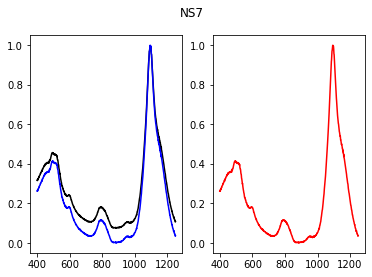

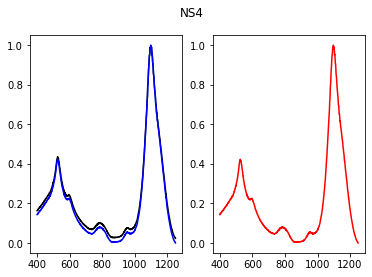

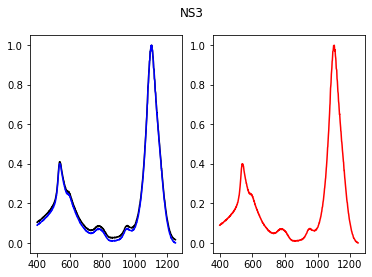

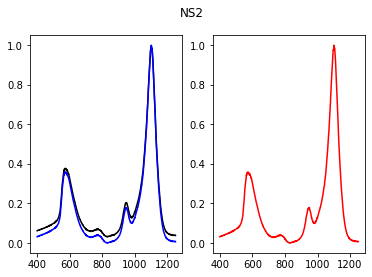

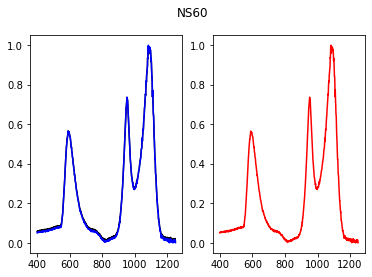

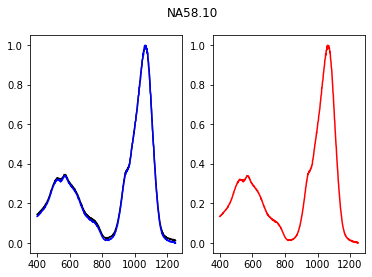

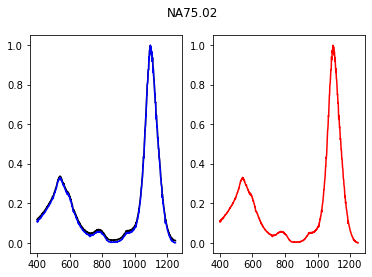

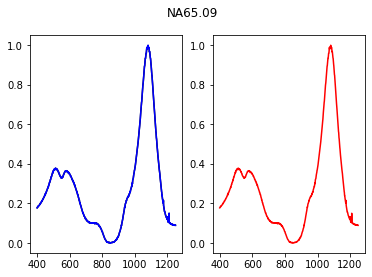

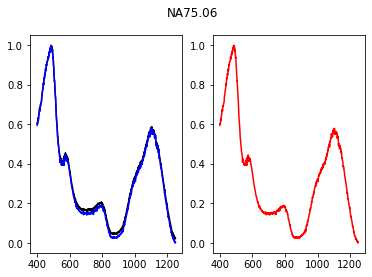

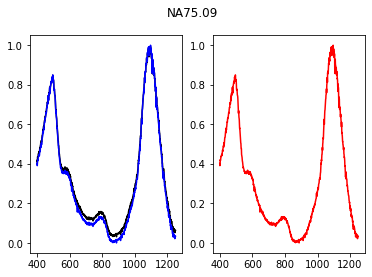

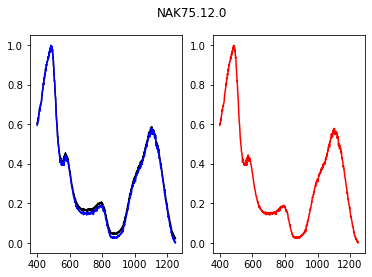

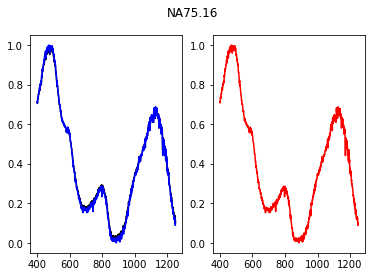

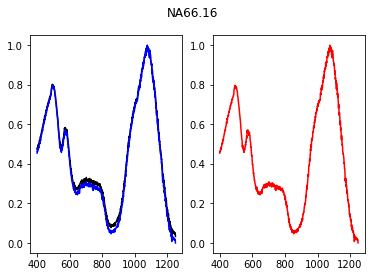

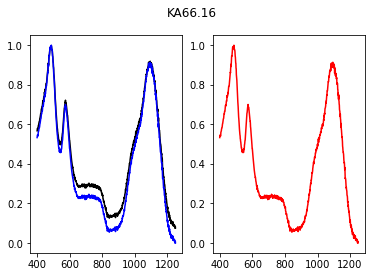

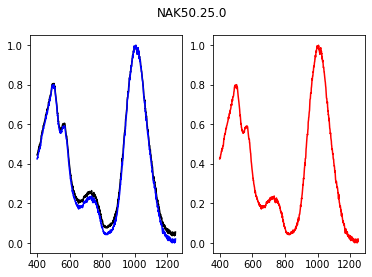

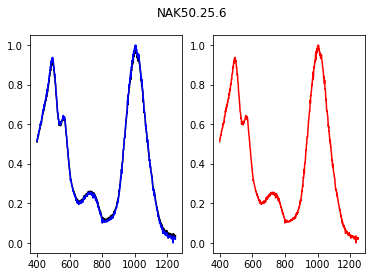

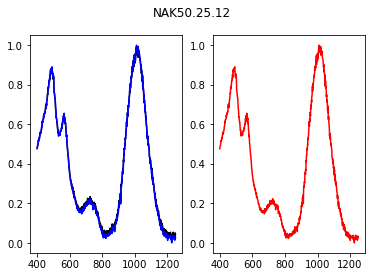

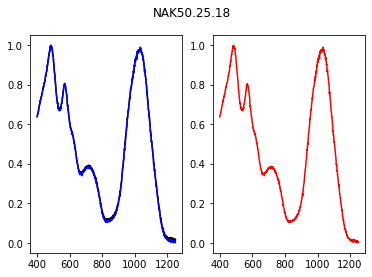

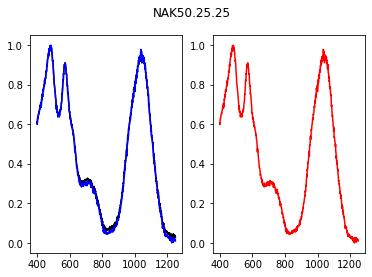

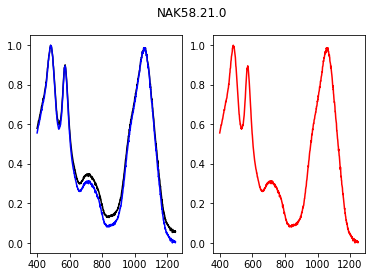

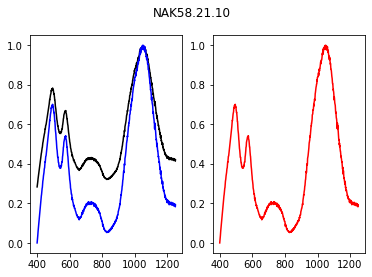

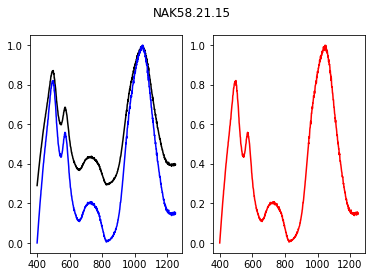

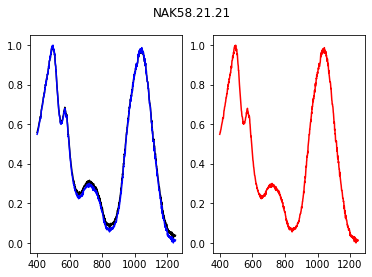

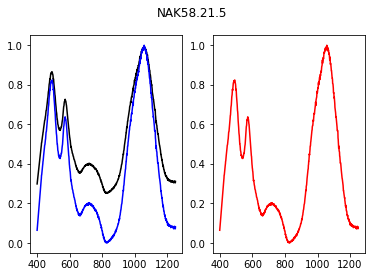

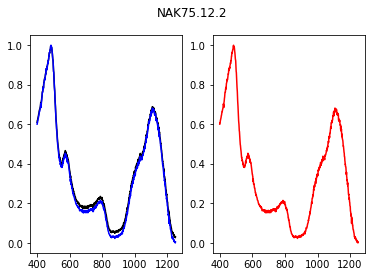

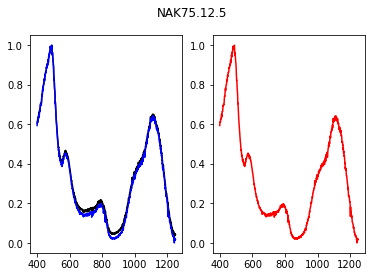

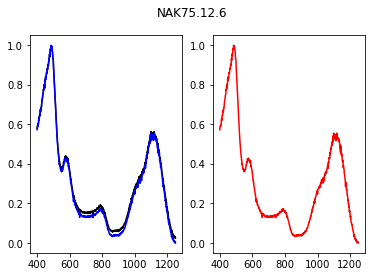

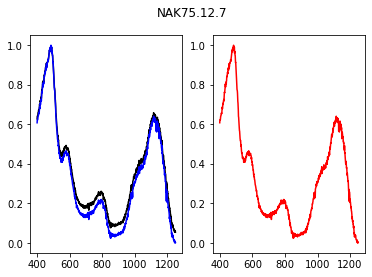

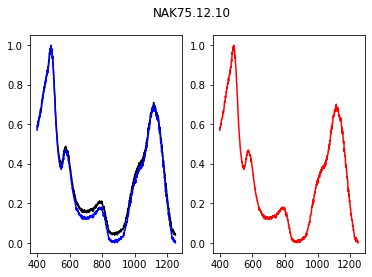

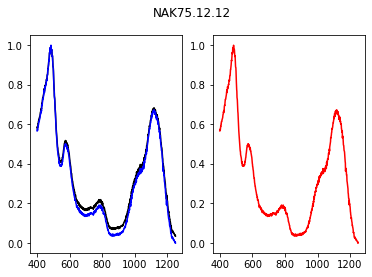

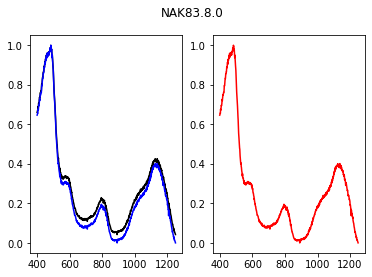

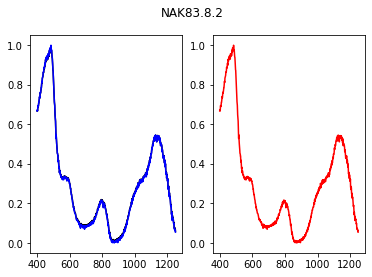

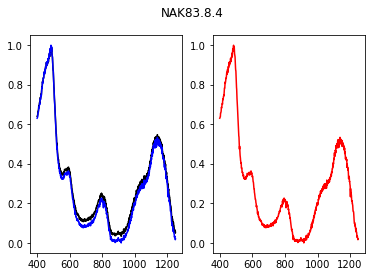

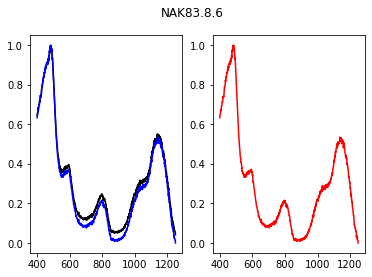

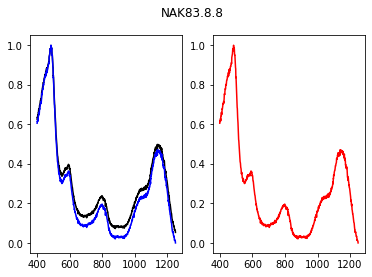

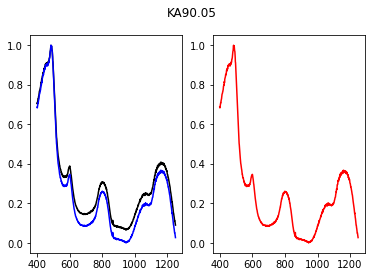

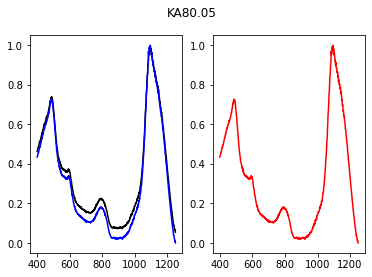

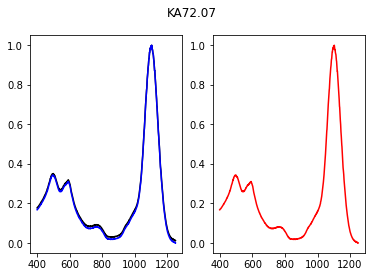

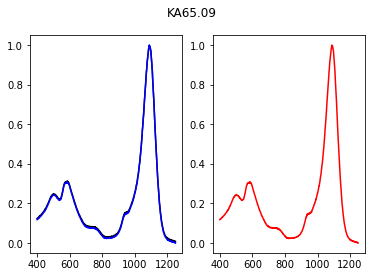

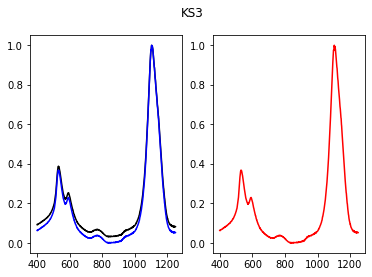

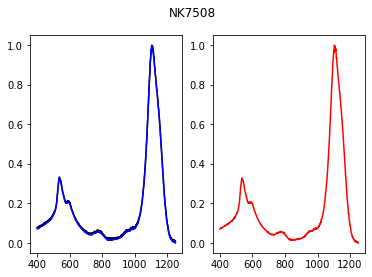

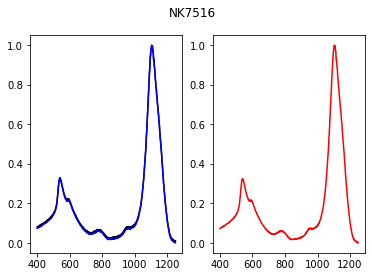

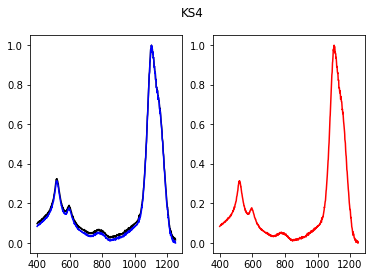

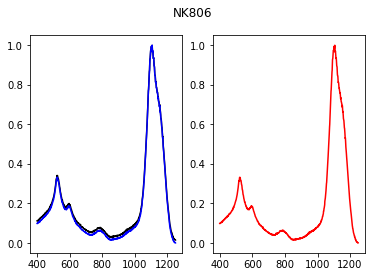

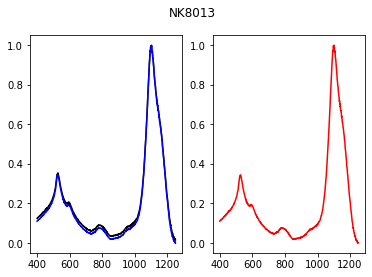

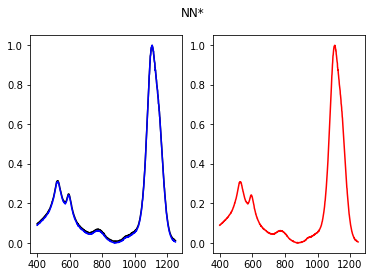

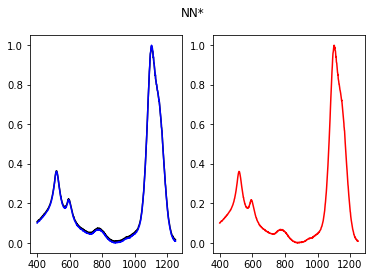

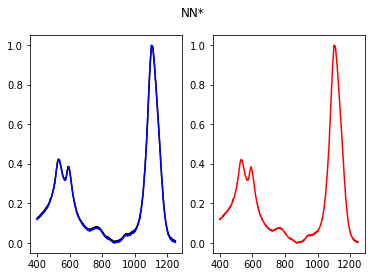

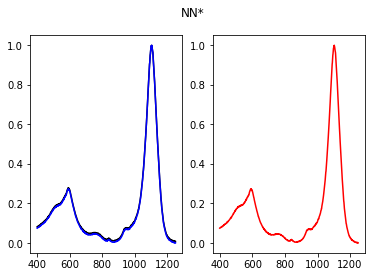

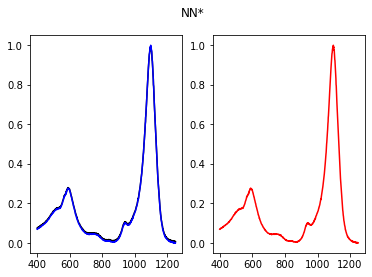

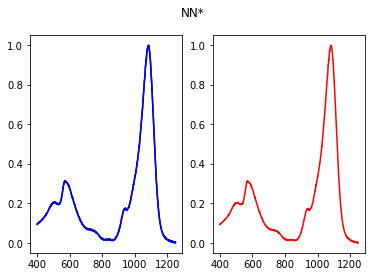

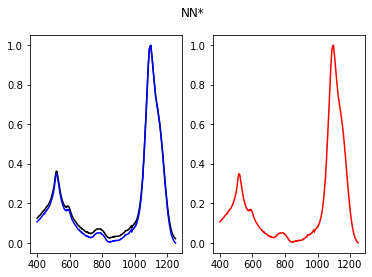

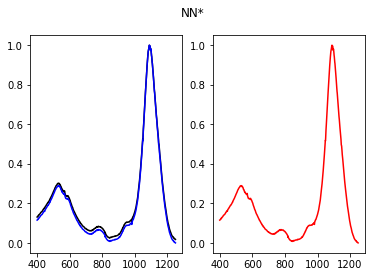

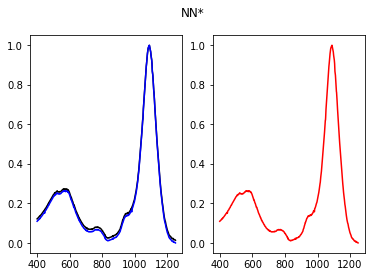

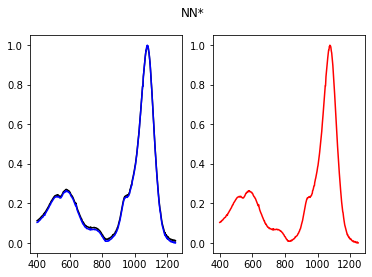

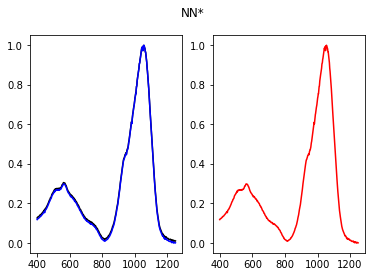

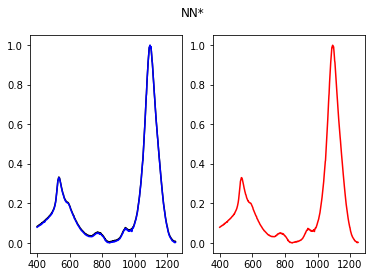

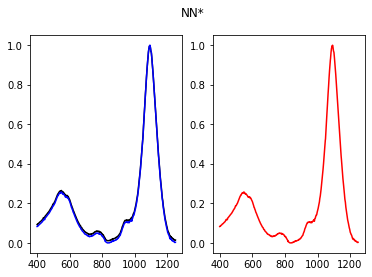

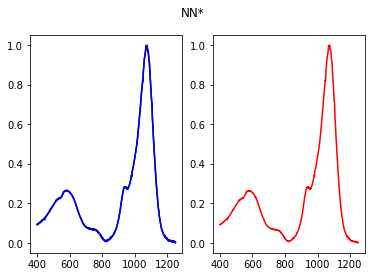

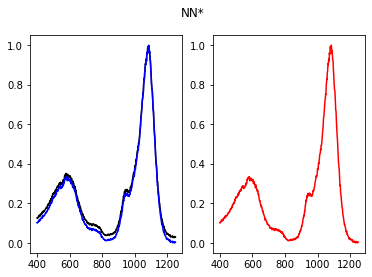

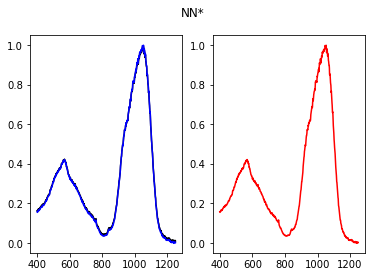

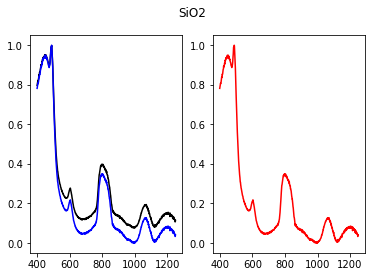

In [9]:
my_liste = pd.read_excel("./data/Database_IPGP.xlsx", "raman")
my_liste.head()

# Run
nb_exp = my_liste.shape[0]
print(nb_exp)
roi_glass = my_liste.loc[:,"lb1":"hb2"]
scaling_factor = 1000.   

x = np.arange(400.,1250.,1.0) # our real x axis, for resampling
spectra = np.ones((len(x),nb_exp))
spectra_long = np.ones((len(x),nb_exp))

xmin = np.ones((nb_exp,1))

for i in range(nb_exp):
    file_name, file_extension=os.path.splitext(my_liste.loc[i,"nom"])
    
    if file_extension == ".txt" or file_extension == ".TXT":
        sp = np.genfromtxt("./data/raman/"+my_liste.loc[i,"nom"],skip_header=1)
    elif file_extension == ".csv":
        sp = np.genfromtxt("./data/raman/"+my_liste.loc[i,"nom"],skip_header=1,delimiter=",")
    else:
        raise InputError("Unsupported file extension")
    
    # we flip the spectra if necessary
    sp = rp.flipsp(sp)
    
    # we apply the long correction
    if my_liste.raw[i] == "yes":
        _, y_long, ese_long = rp.tlcorrection(sp[:,0], sp[:,1]-np.min(sp[:,1]), 23.0,
                                          my_liste.loc[i,"laserfreq"], normalisation="intensity")
    elif my_liste.raw[i] == "no":
        y_long = sp[:,1]-np.min(sp[:,1])
    else:
        raise ValueError("Check the column raw, should be yes or no.")
    
    # resampling 
    y_resampled = rp.resample(sp[:,0], y_long.ravel(), x, fill_value="extrapolate")
    
    print("Spectra %i, checking array size: %i" % (i,sp.shape[0]))
    
    # we get the array position of the minima near 800 automatically
    idx_min = np.where(y_resampled == np.min(y_resampled[(800<= x)&(x<=1000)]))[0]
    xmin[i] = x[idx_min]
    
    # updating the BIR
    bir = np.array([[xmin[i]-5,xmin[i]+5],[1230,1250]])
    
    # Fitting the background
    #y_bas, bas = rp.baseline(x, y_resampled,bir,"poly",polynomial_order=1)
    y_bas = (y_resampled-np.min(y_resampled))/(np.max(y_resampled)-np.min(y_resampled))
    
    # Assigning the spectra in the output array
    spectra_long[:,i] = y_bas.ravel()
    
    # Making a nice figure
    plt.figure()
    plt.suptitle(my_liste.loc[i,"product"])
    plt.subplot(1,2,1)
    plt.plot(x, y_resampled, "k-")
    plt.plot(x, y_bas, "b-")
    
    plt.subplot(1,2,2)
    plt.plot(x,y_bas,"r-")
    
# saving the spectra in HDF5

TOTAL = my_liste.sio2 + my_liste.al2o3 + my_liste.na2o + my_liste.k2o
X = my_liste.loc[:,["sio2","al2o3","na2o","k2o"]].values/TOTAL.values.reshape(-1,1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,spectra_long.T,test_size=0.15, random_state=81) # train-test split
with h5py.File('./data/NKAS_Raman.hdf5', 'w') as f:
    f.create_dataset('X_raman_train', data=X_train)
    f.create_dataset('X_raman_test', data=X_test)
    f.create_dataset('y_raman_train', data=y_train)
    f.create_dataset('y_raman_test', data=y_test)
